# ARIMA Model for time series

The purpose of this project is to go through the ARIMA model to evaluate its performance in a univariate dataset. Also,its performance will be compared with other techniques that are currently available to create predictions in time series using neural networks. 

The dataset that is going to be used, belongs to the UCI repository (http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data)

It has an hourly measurement of the quantity of PM2.5 in the air in the city of Beijing. This dataset comes with other information such as the meteorological data from that city. However, as the purpose of this exercise is to make a model from a univariate variable, this other information is not going to be taken into account. 
We will go step by step through the whole process: starting by importing the data, getting some insights to it, applying the ARIMA model and finally comparing the results with a neural network to evaluate the performance of each model.

(Disclosure)
This post consists of different methods for forecasting time series. However, none of these methods are perfect as there is no perfect way to predict the future, so these results should be taken with care and always with the advice of an expert.

In [1]:
import pandas as pd   
from pandas.plotting import register_matplotlib_converters
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pylab import rcParams
import itertools
from pandas import DataFrame
import math
from sklearn.metrics import mean_squared_error

In [2]:
dataset = pd.read_csv('/Users/migueltorresporta/Documents/Aalto/Individual/Contamination/dataset.csv')

In [3]:
# Transformation for the date
dataset['Timestamp'] = dataset['year'].map(str) + "/" + dataset['month'].map(str) + "/" + dataset['day'].map(str) + ' ' + dataset['hour'].map(str) + ":" + "00:00"
dataset['Timestamp'] = pd.to_datetime(dataset['Timestamp'])

dataset = dataset.set_index('Timestamp')

# Drop the columns that are not going to be used
dataset = dataset.drop(['No',
 'year',
 'month',
 'day',
 'hour',
 'DEWP',
 'TEMP',
 'PRES',
 'cbwd',
 'Iws',
 'Is',
 'Ir'], axis=1)

dataset = dataset.dropna()

### Understanding the data

As I mentioned previously this dataset contains the information about the amount of PM2.5 (ug/m^3) concentration of particles in the air of Beijing. 

These are particles with a diameter of less than 2.5 micrometers that are floating in the air.
(https://www.who.int/news-room/fact-sheets/detail/ambient-(outdoor)-air-quality-and-health)
The world health organization states that exposure to these particles can cause cardiovascular and respiratory diseases and cancer. They estimate that this air pollution caused 4.2 million premature death per year in 2016. 

### Exploratory Data Analysis (EDA)

A quick look at the data to see what we need to handle.

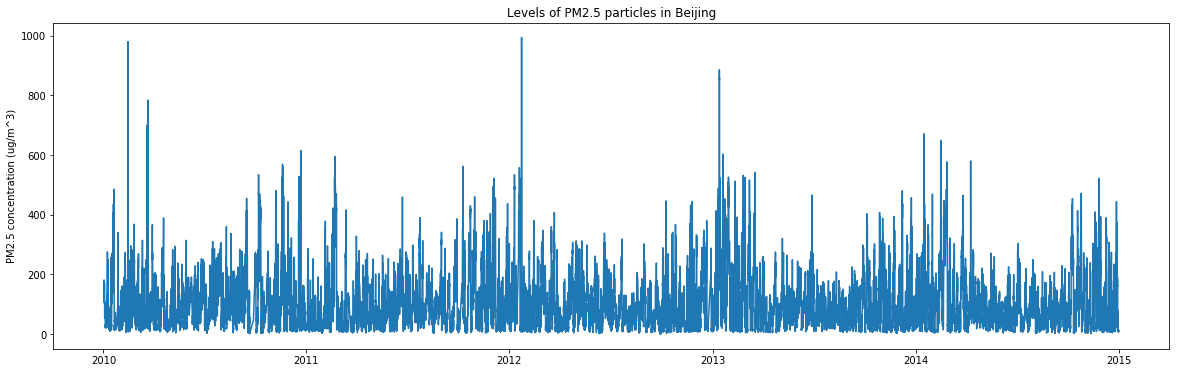

In [4]:
register_matplotlib_converters()
plt.figure(figsize=(20,6))
plt.plot(dataset.index, dataset['pm2.5'])
plt.title("Levels of PM2.5 particles in Beijing")
plt.ylabel("PM2.5 concentration (ug/m^3)")
plt.show()

Regarding this first plot, we can see that at the end and at the beginning of each year the concentration of PM2.5 particles is  higher than in other periods of the year, but it is still fuzzy data and we can barely have a better understanding of what is really happening. Because of this some transformations are needed to be able get a deeper insight into our data. There are many tools available, and here we are only going to use two, but there are many others that can provide better or different insights.

### Grouping by different frames of time

The first method is as simple as to compute the mean of the data measurements by week or month.

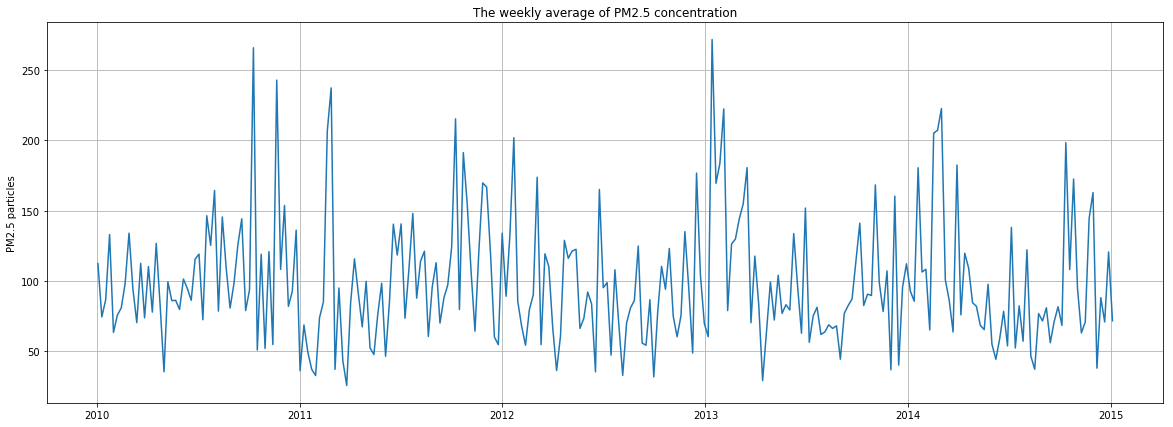

In [5]:
weekly = dataset['pm2.5'].resample('W').mean()
plt.figure(figsize=(20,7))
plt.plot(weekly)
plt.title("The weekly average of PM2.5 concentration")
plt.ylabel("PM2.5 particles")
plt.grid()
plt.show()

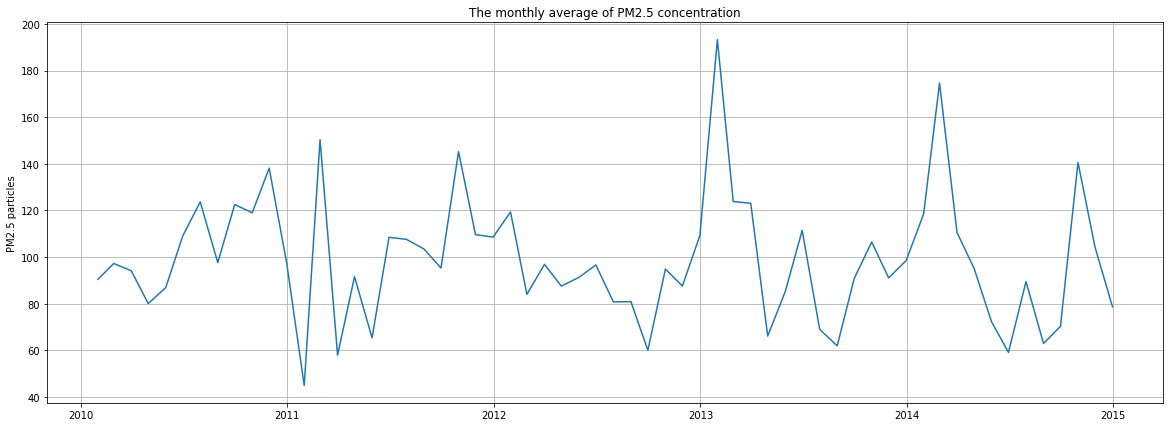

In [6]:
monthly = dataset['pm2.5'].resample('M').mean()
plt.figure(figsize=(20,7))
plt.plot(monthly)
plt.title("The monthly average of PM2.5 concentration")
plt.ylabel("PM2.5 particles")
plt.grid()
plt.show()

As we can see from the plots, the information that we get from the data using this method is not very clear.

### Moving average

This time we are still going to use the mean but in a different way, by using the Moving Average, that computes the average of N given time steps. It will smooth the data allowing the viewer to infer some visible patterns or trends.

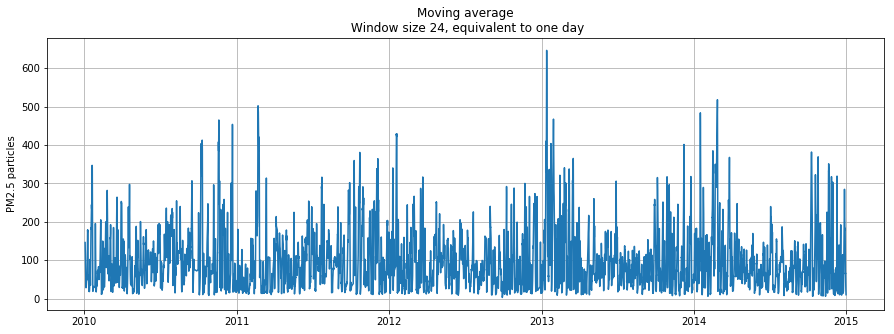

In [7]:
movingAverage = dataset['pm2.5'].rolling(window=24).mean()

plt.figure(figsize=(15,5))
plt.title("Moving average\n Window size 24, equivalent to one day")
plt.ylabel("PM2.5 particles")
plt.plot(movingAverage,label="Rolling mean trend")

plt.grid(True)

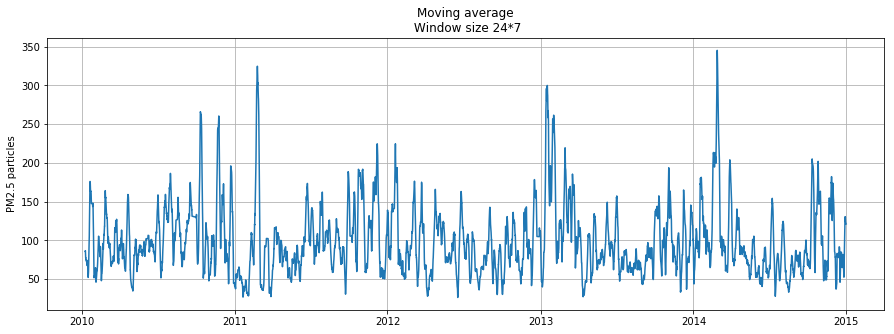

In [8]:
movingAverage = dataset['pm2.5'].rolling(window=(24*7)).mean()

plt.figure(figsize=(15,5))
plt.title("Moving average\n Window size 24*7")
plt.ylabel("PM2.5 particles")
plt.plot(movingAverage,label="Rolling mean trend")

plt.grid(True)

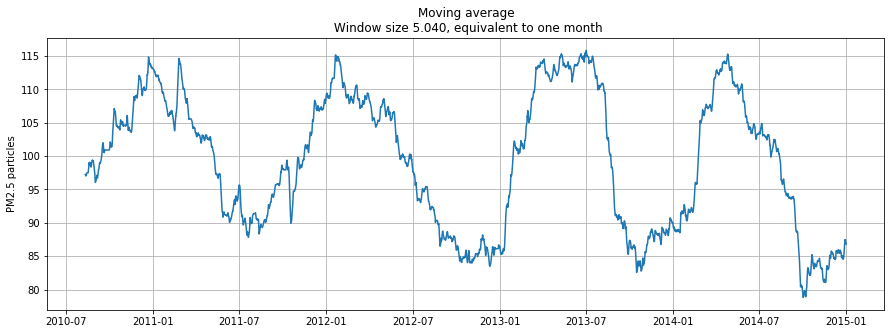

In [9]:
movingAverage = dataset['pm2.5'].rolling(window=(24*7*30)).mean()

plt.figure(figsize=(15,5))
plt.title("Moving average\n Window size 5.040, equivalent to one month")
plt.plot(movingAverage,label="Rolling mean trend")
plt.ylabel("PM2.5 particles")
plt.grid(True)
plt.show()

In this last plot, we can clearly spot some regular patterns. However, these methods are very sensitive to outliers and as we can see in the first plot our data has many of them. 

One can think of these outliers as faulty measures by the devices related to any kind of misfunction. However, doing some research we will find that these levels have been already reached and documented in the capital of China.

https://www.theguardian.com/world/2013/jan/13/beijing-breathe-pollution

### Getting closer to the last weeks

The data that we have evaluated so far looks quite messy, and as the objective of this small project is to apply different forecasting techniques, we are going to focus the efforts in the last four weeks of the entire dataset. By doing so the visualizations are going the be easier and we will see clearly how the predictions fit in our data.

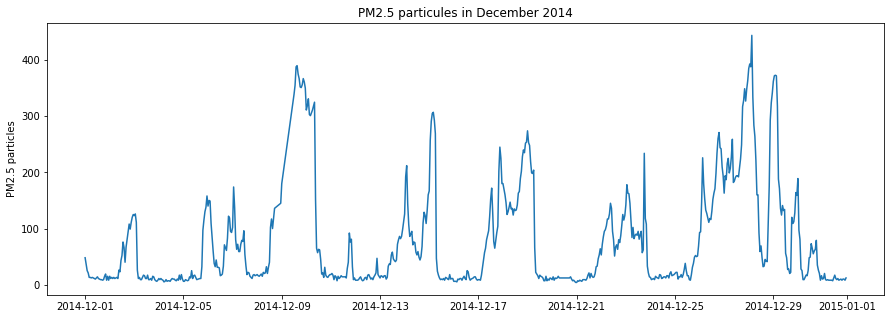

In [10]:
last_weeks = dataset.loc['2014-12':'2014']
plt.figure(figsize=(15,5))
plt.title("PM2.5 particules in December 2014")
plt.ylabel("PM2.5 particles")
plt.plot(last_weeks)

(array([395.,  94.,  81.,  46.,  30.,  22.,  14.,  18.,  15.,   1.]),
 array([  4.,  48.,  92., 136., 180., 224., 268., 312., 356., 400., 444.]),
 <a list of 10 Patch objects>)

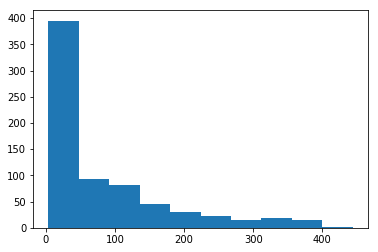

In [11]:
plt.hist(last_weeks['pm2.5'])

In the distribution of the data, we can see that most of the data is grouped in the first values, looking like the exponential distribution.

In [12]:
last_weeks.describe()

,pm2.5
count,716.000000
mean,78.648045
std,93.881828
min,4.000000
25%,12.000000
50%,31.500000
75%,118.000000
max,444.000000


In this data dataset, there are 716 measures of the particle's concentration, around one month of data. With a mean of 78 particles per hour. This means is considered as unhealthy and people should not the exposed during long periods of time to these levels.

### Stationarity

Before applying any statistical model it's important to check if our data is considered as stationary

Stationarity basically means that the properties such as the mean and variance don't change over time. 
(https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm)

There are various ways to check if data is stationary, and one good way is the Test Dickey-Fuller, which states that if the p-value is lower than a given threshold it won't be considered as stationary. 

#### Test Dickey-Fuller

In [13]:
from statsmodels.tsa.stattools import adfuller

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(last_weeks['pm2.5'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

p_value = dftest[1]

if p_value <= 0.01:
    print("\nData is stationary")
else:
    print("\n Data is non-stationary ")


Results of Dickey-Fuller Test:
Test Statistic                  -4.990870
p-value                          0.000023
#Lags Used                       2.000000
Number of Observations Used    713.000000
Critical Value (1%)             -3.439555
Critical Value (5%)             -2.865602
Critical Value (10%)            -2.568933
dtype: float64

Data is stationary


As we proved with Dickey-Fuller Test, fortunately, our data is stationary which means that it doesn't have any kind of trend and thereforeit doesn't need any transformations and we can directly apply ARIMA.

For the cases the time series is non-stationary there are some transformations that can be applied to make it stationary.

# ARIMA 

Before going through ARIMA we are going to split the data that will help us to train the model, and after that evaluate how accurate it is with the test dataset.

Train dataset has the data of 29 days and the test set has 2 days.

The purpose of splitting the dataset is because the model has to be tested with some labelled data, that means to see how the predictions are close to the real data.

In [14]:
train_dataset = last_weeks['2014-12': '2014-12-29']
test_dataset = last_weeks['2014-12-30': '2014']

ARIMA stands for Autorregresive Integrated Moving Average. It is used for time series forecasting.

It contains three different components. The autoregressive the regression of the time series onto himself, the Integrated (I) component is to correct the non-stationarity of the data. The last component Moving Average (MA) models the errors based on past errors.

Each component receives different parameters AR(p), I(d), MA(q). To estimate the value of each parameter we need to get the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF)

#### Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)

This functions will tell us how correlated are the observations in the time series. 

Also, and the main purpose is that the will indicate us which are the best coefficient to use in our ARIMA model.


In our case the pattern in the PACF (significant correlations at the first or second lag followed by correlations that are not significant). The number of significant correlations in the PACF tells us the term of the autoregressive (AR) model. In our case, the coefficient is three.


However, based on the pattern of the ACF (the function progressively decrease), we cannot infer the term for the Moving Average (MA) so the best option is to use zero.

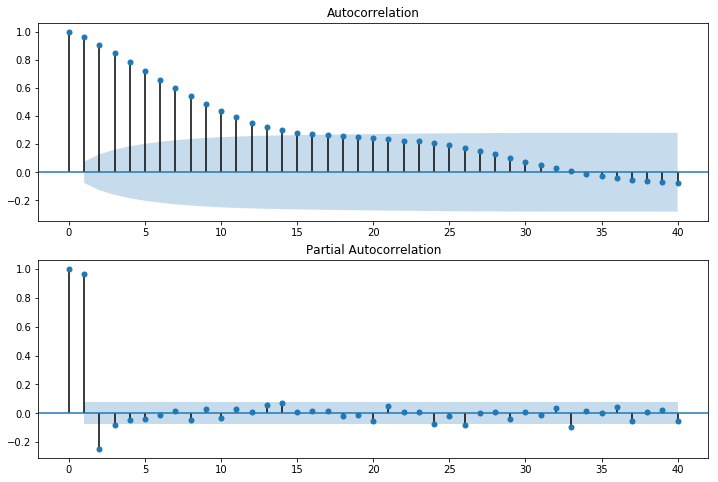

In [15]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_dataset['pm2.5'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_dataset['pm2.5'], lags=40, ax=ax2)

Now we are ready to apply ARIMA to our dataset 

### Applying ARIMA

In [16]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_dataset, order=(3,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/anaconda2/envs/ml/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  pm2.5   No. Observations:                  668
Model:                     ARMA(3, 0)   Log Likelihood               -3098.247
Method:                       css-mle   S.D. of innovations             24.956
Date:                Sat, 13 Apr 2019   AIC                           6206.495
Time:                        19:06:17   BIC                           6229.016
Sample:                             0   HQIC                          6215.219
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          83.2316     18.867      4.411      0.000      46.253     120.210
ar.L1.pm2.5     1.1707      0.039     30.407      0.000       1.095       1.246
ar.L2.pm2.5    -0.1370      0.059     -2.310    

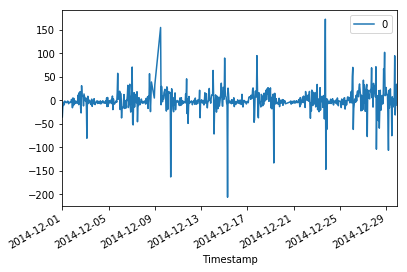

In [17]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

This first plot shows the residuals of our data, and we can observe that most of the data is distributed around zero. Let's see more in detail how this is distributed.

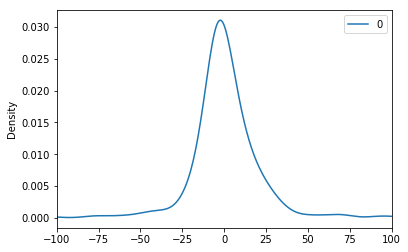

                0
count  668.000000
mean     0.012902
std     25.009371
min   -206.192881
25%     -6.264020
50%     -1.665985
75%      7.713862
max    173.019247


In [18]:
residuals.plot(kind='kde')
plt.xlim([-100.0, 100.0])
plt.show()

print(residuals.describe())

It has a similar shape as the Normal or Gaussian distributions.

### Get some predictions

Now it is time to get some predictions from the model, to evaluate how accurate our model is, we are going to use the test dataset we have made.
Also, we need to perform a rolling forecast, that means after calculating each prediction add it and recalculate the model. 

In [19]:

test = test_dataset.values

X = train_dataset.values
size = len(X)
history = [x for x in X]

predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(3,0,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=157.112307, expected=189.000000
predicted=189.929348, expected=97.000000
predicted=79.233787, expected=81.000000
predicted=69.324004, expected=28.000000
predicted=17.842341, expected=25.000000
predicted=22.027249, expected=9.000000
predicted=9.003631, expected=9.000000
predicted=11.097326, expected=13.000000
predicted=17.344307, expected=17.000000
predicted=21.535414, expected=16.000000
predicted=19.514510, expected=25.000000
predicted=29.680950, expected=48.000000
predicted=55.500485, expected=49.000000
predicted=53.157990, expected=73.000000
predicted=78.621177, expected=65.000000
predicted=66.561864, expected=55.000000
predicted=53.407709, expected=60.000000
predicted=61.132873, expected=63.000000
predicted=65.061317, expected=79.000000
predicted=82.800671, expected=35.000000
predicted=29.700272, expected=26.000000
predicted=22.490799, expected=20.000000
predicted=20.938274, expected=8.000000
predicted=8.572553, expected=16.000000
predicted=19.778446, expected=10.000000
pr

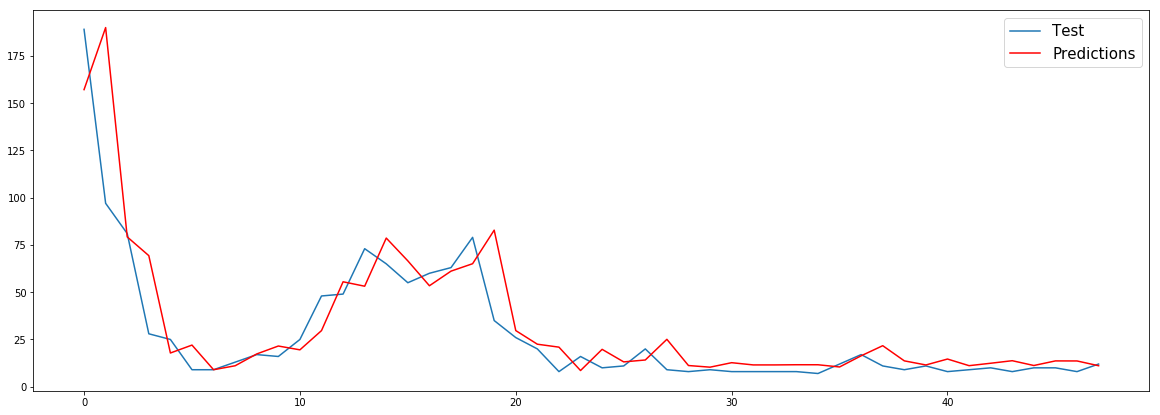

In [20]:
plt.figure(figsize=(20,7))
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions', color='red')
plt.legend(prop={'size': 15})
plt.show()

In [21]:
rmse = error
rmse

338.9659774602706

In the plot above we can see the result of our data in the test data, looking like pretty well fitted!

### Evaluation 

Calculate the Mean Squared Error to obtain the accuracy

In [22]:
error = mean_squared_error(test, predictions)
print('Test Mean Squared Error(MSE): %.3f' % error)

Test Mean Squared Error(MSE): 338.966


# Neural Networks

Now a model of neural networks is going to be applied, concretely we are going to use Recurrent Neural Networks 

### Recurrent Neural Networks (RNN)

RNN is a type of neural networks, which mainly are used in natural language processing (NLP) and predicting Time Series. The basic idea behind these type is that the state of each neuron is stored and fed to the next layer. This is why it is so used in NLP and Time series because it has in count the last observations to predict the next one.

There is a type of RNN called Long Short-Term Memory, it was proposed to solve a huge problem that all the RNN presented, this is called The Vanishing Gradient Problems but we are not going to enter in this kind of details. This is all we need to know to apply to our dataset.

This part is going to be much shorter than the previous one because basically to apply Neural Networks is easier than to apply ARIMA Model

For the sake of the example, we are going to work on the last four weeks.

In [23]:
last_weeks.head()

,pm2.5
Timestamp,
2014-12-01 00:00:00,48.0
2014-12-01 01:00:00,36.0
2014-12-01 02:00:00,25.0
2014-12-01 03:00:00,21.0
2014-12-01 04:00:00,13.0


Also, the datasets to train and test the network are going to be the same to correctly compare the two models.

In [24]:
train_dataset = last_weeks['2014-12': '2014-12-29']
test_dataset = last_weeks['2014-12-30': '2014']

To have a better accuracy in our network we need to first normalize the values of our data.

In [25]:
from sklearn.preprocessing import MinMaxScaler
normalize = MinMaxScaler(feature_range = (0, 1))
train_dataset = normalize.fit_transform(train_dataset)

Now our dataset is ranged between 0 and 1.

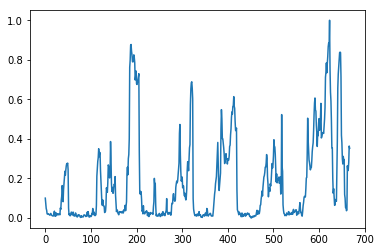

In [26]:
plt.plot(train_dataset)

In [27]:
train_dataset.shape

(668, 1)

The Recurrent Neural Networks predict the new observation based on X lagged observations. For our case, lets try with 168 lagged observations what means around one week to get a new prediction.

In [28]:
X_train = []
y_train = []
for i in range(168, train_dataset.shape[0]):
    X_train.append(train_dataset[i-168:i, 0])
    y_train.append(train_dataset[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Now it's time to create the architecture of the Neural Network! We are going to use Keras, which is a popular framework that is made on top of TensorFlow (the neural network library published by Google). Keras is so famous because it makes the task to build the Networks really easy.

### The architecture of the network

Our network is made by LSTM layers, it contains five networks with 100x200x300x200x100 networks.
I used dropout to improve accuracy and reduce the loss after epoch.
In order to calculate the loss of the network, I used the mean squared error function.

In [29]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 300, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 200, return_sequences = True))
regressor.add(Dropout(0.2))


# Adding a fiveth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [30]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
500/500 [==============================] - 50s 99ms/step - loss: 0.0565
Epoch 2/100
500/500 [==============================] - 45s 91ms/step - loss: 0.0422
Epoch 3/100
500/500 [==============================] - 43s 85ms/step - loss: 0.0350
Epoch 4/100
500/500 [==============================] - 42s 84ms/step - loss: 0.0274
Epoch 5/100
500/500 [==============================] - 44s 88ms/step - loss: 0.0201
Epoch 6/100
500/500 [==============================] - 42s 83ms/step - loss: 0.0176
Epoch 7/100
500/500 [==============================] - 42s 84ms/step - loss: 0.0156
Epoch 8/100
500/500 [==============================] - 41s 81ms/step - loss: 0.0141
Epoch 9/100
500/500 [==============================] - 47s 94ms/step - loss: 0.0132
Epoch 10/100
500/500 [==============================] - 43s 86ms/step - loss: 0.0121
Epoch 11/100
500/500 [==============================] - 40s 80ms/step - loss: 0.0112
Epoch 12/100
500/500 [====

500/500 [==============================] - 35s 69ms/step - loss: 0.0048
Epoch 95/100
500/500 [==============================] - 34s 69ms/step - loss: 0.0054
Epoch 96/100
500/500 [==============================] - 35s 69ms/step - loss: 0.0054
Epoch 97/100
500/500 [==============================] - 34s 69ms/step - loss: 0.0058
Epoch 98/100
500/500 [==============================] - 34s 69ms/step - loss: 0.0046
Epoch 99/100
500/500 [==============================] - 36s 72ms/step - loss: 0.0047
Epoch 100/100
500/500 [==============================] - 35s 70ms/step - loss: 0.0061


Now the model is fitted to our train dataset the model and it's time to create the predictions.

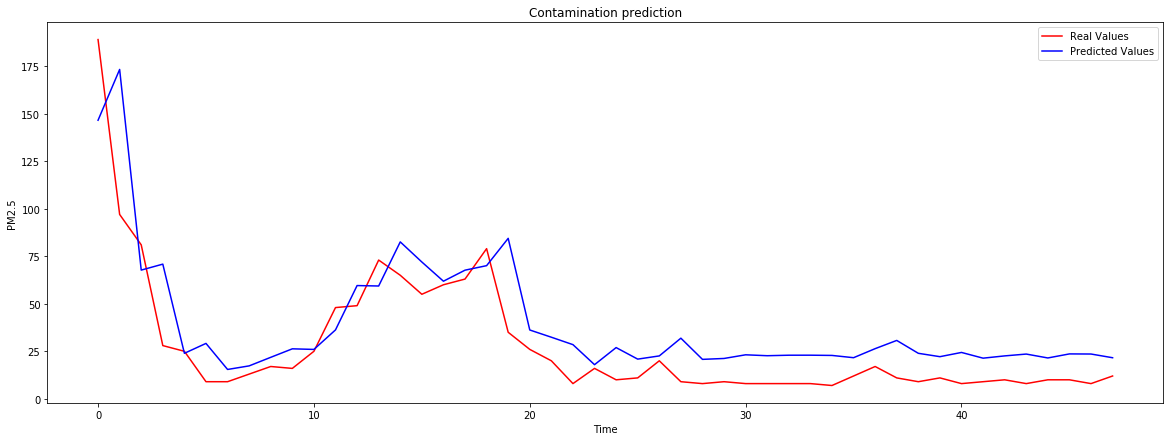

In [31]:
inputs = last_weeks[len(last_weeks) - len(test_dataset) - 168 :].values
inputs = inputs.reshape(-1,1)
inputs = normalize.transform(inputs)

X_test = []
for i in range(168, len(inputs)):
    X_test.append(inputs[i-168:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted = regressor.predict(X_test)
predicted = normalize.inverse_transform(predicted)

# Visualising the results
plt.figure(figsize=(20,7))
plt.plot(test_dataset['pm2.5'].values, color = 'red', label = 'Real Values')
plt.plot(predicted, color = 'blue', label = 'Predicted Values')
plt.title('Contamination prediction')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

It looks that the predictions suit well to the real values

In [32]:
mean_squared_error(test_dataset['pm2.5'].values, predicted)

401.1344870105166

## Conclusions

We saw many different things starting by different concepts of statistical model and time series manipulations (different transformations, stationarity in time series, autocorrelation functions). Following by one statistical model (ARIMA) and Recurrent Neural Networks applied to our particular data set.

We can see that ARIMA performs better to our test set with a smaller Mean squared error of 338.96 compared to 542 provided by the neural networks.

There are still some other things to try but for this specific dataset with around 720 observations the price goes to the statistical model!

## Future projects

Once this is understood the first thing that comes to mind is to apply the same methods to the whole dataset (with more than 41.000 observations. Here we will see which one behave better with a higher amount of data.

The next (still with the same dataset) is to use the other variables to create the forecasting. In the beginning, we have got rid of around 7 different variables with valuable information that we are not using in our model. 

We can also, improve the architecture of the neural network until we reach an optimal point.
There is another statistical model such as Seasonal Arima (SARIMA) that can maybe improve the metrics.

Finally and the purpose of all of this study is to extract useful insights from the data, in our case, it will be about the PM2.5 levels in Beijing.

... but let see all these things in new posts.

# References

https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

https://towardsdatascience.com/forecasting-exchange-rates-using-arima-in-python-f032f313fc56

https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima/data

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/